## Load common functions

In [1]:
%run commons.ipynb

2024-08-12 19:46:18.827601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 19:46:18.827656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 19:46:18.829094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 19:46:18.923118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 19:46:20.027948: W tensorflow/compiler/

In [2]:
speakers_root_dir = "/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data"
dataset_original_name = "50_speakers_dataset"
sample_length = 30

# speakers_root_dir = "/mnt/c/Magisterka Bazy Danych/LibreSpeech/train-clean-360"
# dataset_original_name = "LibreSpeech"
# sample_length = 30

# speakers_root_dir = "/mnt/c/Magisterka Bazy Danych/TIMIT/TRAIN"
# dataset_original_name = "Timit"
# sample_length = 3

# batch_size = 32: Określa, ile próbek danych jest przetwarzanych jednocześnie podczas jednej iteracji uczenia. Wybór odpowiedniej wartości batch_size wpływa na szybkość uczenia, stabilność algorytmu optymalizacji oraz wykorzystanie pamięci. Zbyt mały batch_size może prowadzić do niestabilnego procesu uczenia, podczas gdy zbyt duży może spowolnić trening i ograniczać możliwości uczenia się modelu na złożonych zależnościach w danych. W tym przypadku, na drodze eksperymentalnej ustalono, że wartość 32 stanowi dobry kompromis między tymi czynnikami.
# 
# steps_per_epoch = 128: Określa, ile razy wagi modelu będą aktualizowane w trakcie jednej epoki. Epoka to pełny cykl przejścia przez cały zestaw danych treningowych. Wartość steps_per_epoch wpływa na czas trwania każdej epoki oraz na to, jak często model będzie miał okazję uczyć się na nowych danych. Zbyt mała wartość może prowadzić do niedostatecznego wykorzystania danych treningowych, podczas gdy zbyt duża może wydłużyć czas treningu bez znaczącej poprawy wyników. W tym przypadku, wartość 128 została uznana za optymalną dla badanych zbiorów danych.


# Start with a small batch size (e.g., 16, 32). This allows for more frequent updates and can help avoid getting stuck in local minima.
# Steps per epoch: This represents the number of mini-batch gradient descent updates performed in a single training epoch.
# Batch size: This defines the number of training samples used in each mini-batch update.
# Steps per epoch = Total training samples / Batch size (rounded down to the nearest whole number)
batch_size = 32

# Steps per epoch = Total training samples / Batch size (rounded down to the nearest whole number)
# steps_per_epoch = int(math.floor(num_of_train_samples / batch_size)) # this was very bad performance for small dataset -> cal_acc didn't raise and always stopped
steps_per_epoch = 128
# steps_per_epoch = int(math.floor(num_of_train_samples / batch_size)) 

# Set parameters for a more detailed spectrogram
# It has all the frequency bands from the FFT, (n_fft/2)+1 bands, 1025 for n_fft=2048
n_fft = 512 
# n_fft = 2048

# hop_length - number of audio samples between adjacent STFT columns.
hop_length = 1024  # Decrease hop length for better time resolution,


# chosen_feature = "Stft" # Short Term Fourier Transform (STFT)
# n_fft = 256 
chosen_feature = "Mel" # A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.
# chosen_feature = "MFCC" # MFCC — Mel-Frequency Cepstral Coefficients
# chosen_feature = "ChromaStft"
# chosen_feature = "SpectralContrast"

model_name = "MyCNN"; use_3_channels = False
# model_name = "BetterCNN"; use_3_channels = False
# model_name = "ResNet50"; use_3_channels = True

n_mfcc = 128
n_mels = 128
n_chroma = 128 # chroma bins - same as mfcc (optimal value based on experiments) number of Mel bands to generate

sr = 16000

dataset_variant = f"{speakers_root_dir.split('/')[-1]}"

parent_dir = f"./data/{dataset_original_name}/{dataset_variant}"
numpy_samples_dir = f"{parent_dir}/numpy_samples"
random_samples_dir = f"{parent_dir}/random_samples"
tf_datasets_dir = f"{parent_dir}/TFRecords"
models_dir = f"{parent_dir}/models"
results_dir = f"{parent_dir}/results"

model_specification = f"{model_name}-{hop_length}hops-{n_fft}nfft"

# we will use this identifier to save results for different models/settings
unique_identifier = f"{sample_length}s-{chosen_feature}-{model_specification}"

## Create and/or clear directories

In [3]:
import shutil
import os

def create_directory(dir_path):
    # Create the directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory {dir_path} created.")
    else:
        print(f"Directory {dir_path} already exists.")

def create_or_clear_directory(dir_path):
    # Create the directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory {dir_path} created.")
    else:
        print(f"Directory {dir_path} already exists. Clearing it.")
        if os.path.exists(dir_path):
            # Remove the directory and its contents
            shutil.rmtree(dir_path)
            os.makedirs(dir_path)
            print(f"Directory {dir_path} cleared.")
            
# Example usage:
create_directory(parent_dir)
create_directory(numpy_samples_dir)
create_or_clear_directory(random_samples_dir)
create_directory(tf_datasets_dir)
create_directory(models_dir)
create_directory(results_dir)

Directory ./data/50_speakers_dataset/50_speakers_audio_data already exists.
Directory ./data/50_speakers_dataset/50_speakers_audio_data/numpy_samples already exists.
Directory ./data/50_speakers_dataset/50_speakers_audio_data/random_samples already exists. Clearing it.
Directory ./data/50_speakers_dataset/50_speakers_audio_data/random_samples cleared.
Directory ./data/50_speakers_dataset/50_speakers_audio_data/TFRecords already exists.
Directory ./data/50_speakers_dataset/50_speakers_audio_data/models already exists.
Directory ./data/50_speakers_dataset/50_speakers_audio_data/results already exists.


## Common data loading function - concat all the data into one big file and then split into 30 seconds fragments

In [4]:
import os
import librosa
import numpy as np
import logging
import random
import time
import math
import soundfile as sf

def load_all_audio_files_from_LibreSpeech(speaker_dir, sr=16000, show_logs=False):
    speaker_samples = []
    total_files_loaded = 0
    # Traverse the parent directory
    for root, dirs, files in os.walk(speaker_dir):
        for dir in dirs:
            num_files_loaded_per_dir = 0
            # Find the .wav file in the current directory
            dir_path = os.path.join(root, dir)
            for file in os.listdir(dir_path):
                if file.endswith((".wav", ".mp3", ".flac")):
                    try:    
                        file_path = os.path.join(dir_path, file)
                        # Load the audio file
                        sample, _ = librosa.load(file_path, sr=sr)
                        speaker_samples.append(sample)
                        num_files_loaded_per_dir += 1

                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")    
                        
            if show_logs:
                logging.info(f"Loaded {num_files_loaded_per_dir} files from directory: {dir_path}")     

            total_files_loaded += num_files_loaded_per_dir
        
    return speaker_samples, total_files_loaded

def load_all_audio_files_from_Timit(speaker_dir, sr=16000, show_logs=False):
    speaker_samples = []
    total_files_loaded = 0
    # Traverse the parent directory
    for audio_file in os.listdir(speaker_dir):
        
        # Find the ".wav", ".mp3", ".flac" files in the current directory
        if audio_file.endswith((".wav", ".mp3", ".flac")):
            try:    
                file_path = os.path.join(speaker_dir, audio_file)
                # Load the audio file
                sample, _ = librosa.load(file_path, sr=sr)
                speaker_samples.append(sample)
                total_files_loaded += 1

            except Exception as e:
                print(f"Error loading {file_path}: {e}")    
                    
    if show_logs:
        logging.info(f"Loaded {total_files_loaded} files from directory: {speaker_dir}")
            

    return speaker_samples, total_files_loaded

def load_and_concatenate_audio(speaker_dir, target_duration=30, sr=16000, show_logs=False):
    """
    Loads and concatenates audio files from a speaker directory, ensuring a target duration.

    Args:
        speaker_dir (str): Path to the speaker directory.
        target_duration (int, optional): Target duration of sample in seconds (default: 30).
        sr (int, optional): Sample rate (default: 16000 Hz).
        show_logs (bool, optional): Enable logging (default: False).
    
    Returns:
        tuple: A tuple containing (audio_samples, labels) where audio_samples is a list of NumPy arrays representing audio data and labels is a list of corresponding speaker labels.
    """
    start_time = time.time()
    global iter
    speaker_samples = []
    labels = []
    num_of_files_loaded = 0
    
    speaker_label = speaker_dir.split("/")[-1]
    
    if show_logs:
        logging.info(f"Extracting audio samples for speaker {speaker_label} from: {speaker_dir}")
    
    
    if dataset_original_name == "LibreSpeech":
        speaker_samples, num_of_files_loaded = load_all_audio_files_from_LibreSpeech(speaker_dir, sr=16000, show_logs=show_logs)
    
    elif dataset_original_name == "Timit" or dataset_original_name == "50_speakers_dataset":
        speaker_samples, num_of_files_loaded  = load_all_audio_files_from_Timit(speaker_dir, sr=16000, show_logs=show_logs)
            
                
    # Concatenate all audio clips
    concatenated_audio = np.concatenate(speaker_samples)
    
    # Calculate the number of samples in a target duration
    fragment_length = int(target_duration * sr)
    
    # Split the concatenated audio into 30-second fragments
    fragments = []
    total_samples = len(concatenated_audio)
    num_full_fragments = total_samples // fragment_length
    
    
    for i in range(num_full_fragments):
        start_sample = i * fragment_length
        end_sample = start_sample + fragment_length
        fragment = concatenated_audio[start_sample:end_sample]
        fragments.append(fragment)
        labels.append(speaker_label)
    
    # save random files to validate if they had been concatenated correctly
    # save two files to check if they aren't overlapping
    if random.randint(0, int(num_speakers/5)) == int(num_speakers/5):
        output_filename = f"{random_samples_dir}/speaker_{speaker_label}"
        random_idx = random.randint(0, len(fragments)-2)
        sf.write(f"{output_filename}_1.wav", fragments[random_idx], sr)
        sf.write(f"{output_filename}_2.wav", fragments[random_idx+1], sr)

        logging.info(f"Saved 2 random fragments for speaker with label: \"{speaker_label}\"")
        
    if len(fragments) < 8:
        logging.warning(f"Number of samples for speaker: \"{speaker_label}\" is not sufficient: ({len(fragments)}). This speaker will not be added to the dataset.")
        return
        
    if show_logs:
        num_samples = len(fragments)
        total_duration = num_samples * target_duration
    
        logging.info(f"  Summary for the Speaker {speaker_label}:")
        logging.info(f"    Audio files read: {num_of_files_loaded}")
        logging.info(f"    Samples created: {num_samples}")
        logging.info(f"    Samples duration: {target_duration}")
        logging.info(f"    Total duration: {total_duration:.2f} seconds")
        
    spectrogram_samples = extract_features(samples=fragments, feature=chosen_feature, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels, n_chroma=n_chroma, n_mfcc=n_mfcc, show_logs=show_logs)    
    
    end_time = time.time()
    return spectrogram_samples, np.array(labels), speaker_label, start_time, end_time

## Load dataset using parallel computing

In [5]:
from multiprocessing import cpu_count

from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import sys

if __name__ == '__main__':
    # Get all parent directories in the root directory
    parent_data_dirs = [os.path.join(speakers_root_dir, d) for d in os.listdir(speakers_root_dir) if os.path.isdir(os.path.join(speakers_root_dir, d))]
    
    # Initialize an empty list to hold all speakers' directories
    speaker_dirs = []
    
    # LibreSpeech files' structure: 
    # ./
    #     ├── Speaker1/
    #     │   ├── VoiceSamples1/
    #     │   ├── VoiceSamples2/
    #     │   └── ...
    #     ├── Speaker2/
    #     │   ├── VoiceSamples1/
    #     │   ├── VoiceSamples2/
    #     │   └── ...
    #     ├── ...
    #     └── SpeakerN/
    #         ├── VoiceSamples1/
    #         ├── VoiceSamples2/
    #         └── ...
    if dataset_original_name == "LibreSpeech":
        print(f"Scanning speakers' dirs (first 10 directories): {parent_data_dirs[:10]}")
        num_speakers = len(parent_data_dirs)
        print(f"Started processing of dataset containing {num_speakers} speakers.")
        speaker_dirs = parent_data_dirs
        
        
    
    # Timit files' structure: 
    # ./TRAIN/
    #     ├── Dialect1/
    #     │   ├── Speaker1/
    #     │   ├── Speaker2/
    #     │   └── ...
    #     ├── Dialect2/
    #     │   ├── Speaker3/
    #     │   ├── Speaker4/
    #     │   └── ...
    #     ├── ...
    #     ├── Dialect8/
    
    elif dataset_original_name == "Timit":   
        # Iterate through each parent directory and get the list of subdirectories
        for speaker_dir in parent_data_dirs:
            speaker_sub_dir = [os.path.join(speaker_dir, sd) for sd in os.listdir(speaker_dir) if os.path.isdir(os.path.join(speaker_dir, sd))]
            speaker_dirs.extend(speaker_sub_dir)
        
        num_speakers = len(speaker_dirs)
        print(f"Scanned speakers' directories (first 10 dirs): {speaker_dirs[:10]}")
        print(f"Started processing of dataset containing {num_speakers} speakers.")
    
    # 50 speakers' struture:
    # ./
    #     ├── Speaker1/
    #     ├── Speaker2/
    #     └── ...
    elif dataset_original_name == "50_speakers_dataset":
        num_speakers = len(parent_data_dirs)
        speaker_dirs = parent_data_dirs
        print(f"Scanned speakers' directories (first 10 dirs): {speaker_dirs[:10]}")
        print(f"Started processing of dataset containing {num_speakers} speakers.")
    

    features = []
    labels = []
    timestamps = []
    with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
        futures = [executor.submit(load_and_concatenate_audio, speaker_dir, sample_length, 16000, show_logs=True) for speaker_dir in speaker_dirs]

        for future in tqdm(as_completed(futures), total=num_speakers):
            result = future.result()
            if result is not None:
                features.append(result[0])
                labels.append(result[1])
                timestamps.append((result[2], result[3], result[4]))

    
    # Calculate total memory usage
    total_memory = 0
    for arr in features:
        total_memory += arr.nbytes

    print(f"Extracted features list size: {total_memory // 1024 // 1024} MB")  

    # Convert lists to numpy arrays
    features = np.concatenate(features, dtype=np.float32) # when using float64 - usag will be twice as high
    labels = np.concatenate(labels)
    
    features_size = sys.getsizeof(locals().get('features'))
    print(f"Extracted features nd.array size: {features_size // 1024 // 1024} MB")  

    print(f"Total speakers processed: {num_speakers}")
    print(f"Loaded {len(features)} audio samples with corresponding labels.")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")        

Scanned speakers' directories (first 10 dirs): ['/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0026', '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0027', '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0028', '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0029', '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0030', '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0031', '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0032', '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0033', '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0034', '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0035']
Started processing of dataset containing 50 speakers.


2024-08-12 19:46:21,971 - INFO - Extracting audio samples for speaker Speaker0026 from: /mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0026
2024-08-12 19:46:21,972 - INFO - Extracting audio samples for speaker Speaker0027 from: /mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0027
  0%|          | 0/50 [00:00<?, ?it/s]2024-08-12 19:46:21,974 - INFO - Extracting audio samples for speaker Speaker0028 from: /mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0028
2024-08-12 19:46:21,984 - INFO - Extracting audio samples for speaker Speaker0041 from: /mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0041
2024-08-12 19:46:21,983 - INFO - Extracting audio samples for speaker Speaker0039 from: /mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0039
2024-08-12 19:46:21,974 - INFO - Extracting audio samples for speaker Speaker0029 from: /mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data/Speaker0

Extracted features list size: 1131 MB
Extracted features nd.array size: 1131 MB
Total speakers processed: 50
Loaded 4942 audio samples with corresponding labels.
Features shape: (4942, 128, 469)
Labels shape: (4942,)


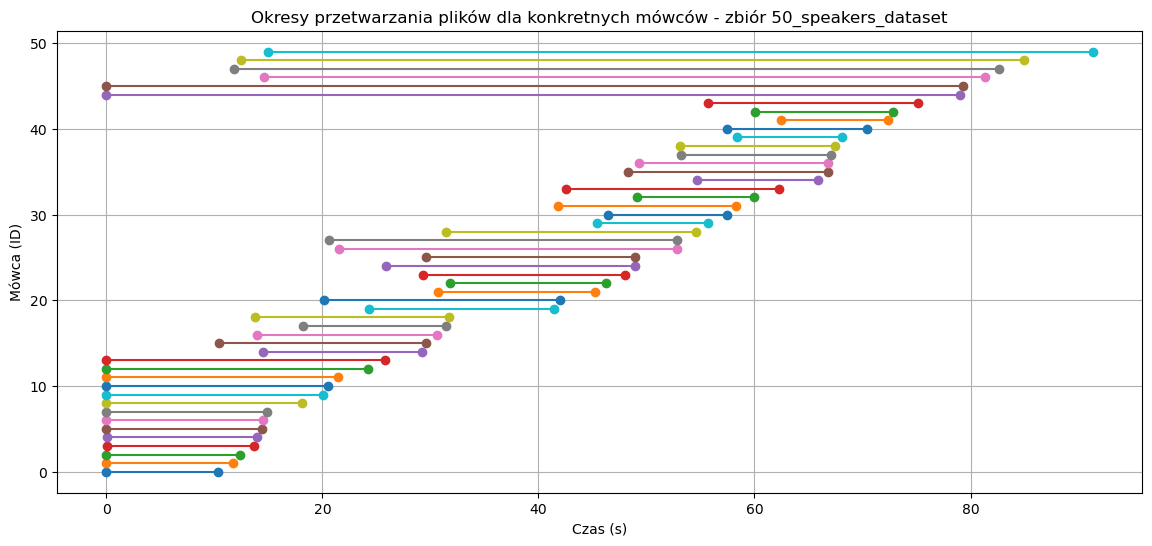

In [6]:
import pandas as pd
import matplotlib.pyplot as  plt

df = pd.DataFrame(timestamps, columns=['Speaker', 'Start Time', 'End Time'])

df['Duration'] = df['End Time'] - df['Start Time']

df['Start Time Offset'] = df['Start Time'] - df['Start Time'].min()
df['End Time Offset'] = df['End Time'] - df['Start Time'].min()


plt.figure(figsize=(14, 6))

for index, row in df.iterrows():
    plt.plot([row['Start Time Offset'], row['End Time Offset']],
             [index, index], marker='o', label=f'Task {row["Speaker"]}')

plt.xlabel('Czas (s)')
plt.ylabel('Mówca (ID)') # directories in particular so it is speaker
plt.title(f'Okresy przetwarzania plików dla konkretnych mówców - zbiór {dataset_original_name}')
plt.grid(True)
# plt.legend()
plt.show()
plt.style.use("ggplot")

## Optionally save processed samples on disk

In [7]:
# Save extracted features as numpy
print(f"Saving features with shape: {features.shape}")
print(f"Saving labels with shape: {labels.shape}")
np.savez(f"{numpy_samples_dir}/{unique_identifier}", features=features, labels=labels)
print(f"Saved loaded samples in directory: {numpy_samples_dir}/{unique_identifier}.npz")

Saving features with shape: (4942, 128, 469)
Saving labels with shape: (4942,)
Saved loaded samples in directory: ./data/50_speakers_dataset/50_speakers_audio_data/numpy_samples/30s-Mel-MyCNN-1024hops-512nfft.npz


## Optionally load a data

In [8]:
import numpy as np

# Load the data
data = np.load(f"{numpy_samples_dir}/{unique_identifier}.npz")

# Access the samples and labels
features = data["features"]
labels = data["labels"]

print(f"Loaded features shape: {features.shape}")
print(f"Loaded labels shape: {labels.shape}")

Loaded features shape: (4942, 128, 469)
Loaded labels shape: (4942,)


## Play random voice samples

In [9]:
from IPython.display import Audio, display, HTML
import random

def get_random_consecutive_wav_files(directory):
    # List all files in the directory
    files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    
    # Sort the files to maintain the order in which they appear
    files.sort()
    
    # Ensure there are at least two files to select
    if len(files) < 2:
        raise ValueError("Not enough wav files in the directory to select a consecutive pair.")
    
    # Get the list of valid indices (only odd numbers)
    odd_indices = list(range(0, len(files) - 1, 2))
    
    # Randomly select an index from the odd_indices list
    index = random.choice(odd_indices)
    
    # Get the selected file and the next one
    file1 = os.path.join(directory, files[index])
    file2 = os.path.join(directory, files[index + 1])
    
    return file1, file2

file1, file2 = get_random_consecutive_wav_files(random_samples_dir)

audio1 = Audio(file1)
audio2 = Audio(file2)

display(HTML(f"""
<div>
    <div style="float: left; margin-right: 20px;">
        {audio1._repr_html_()}
    </div>
    <div style="float: left;">
        {audio2._repr_html_()}
    </div>
</div>
<div style="clear: both;"></div>
"""))

## Show random extracted features

[INFO] Plotting sample fragments of extracted features...


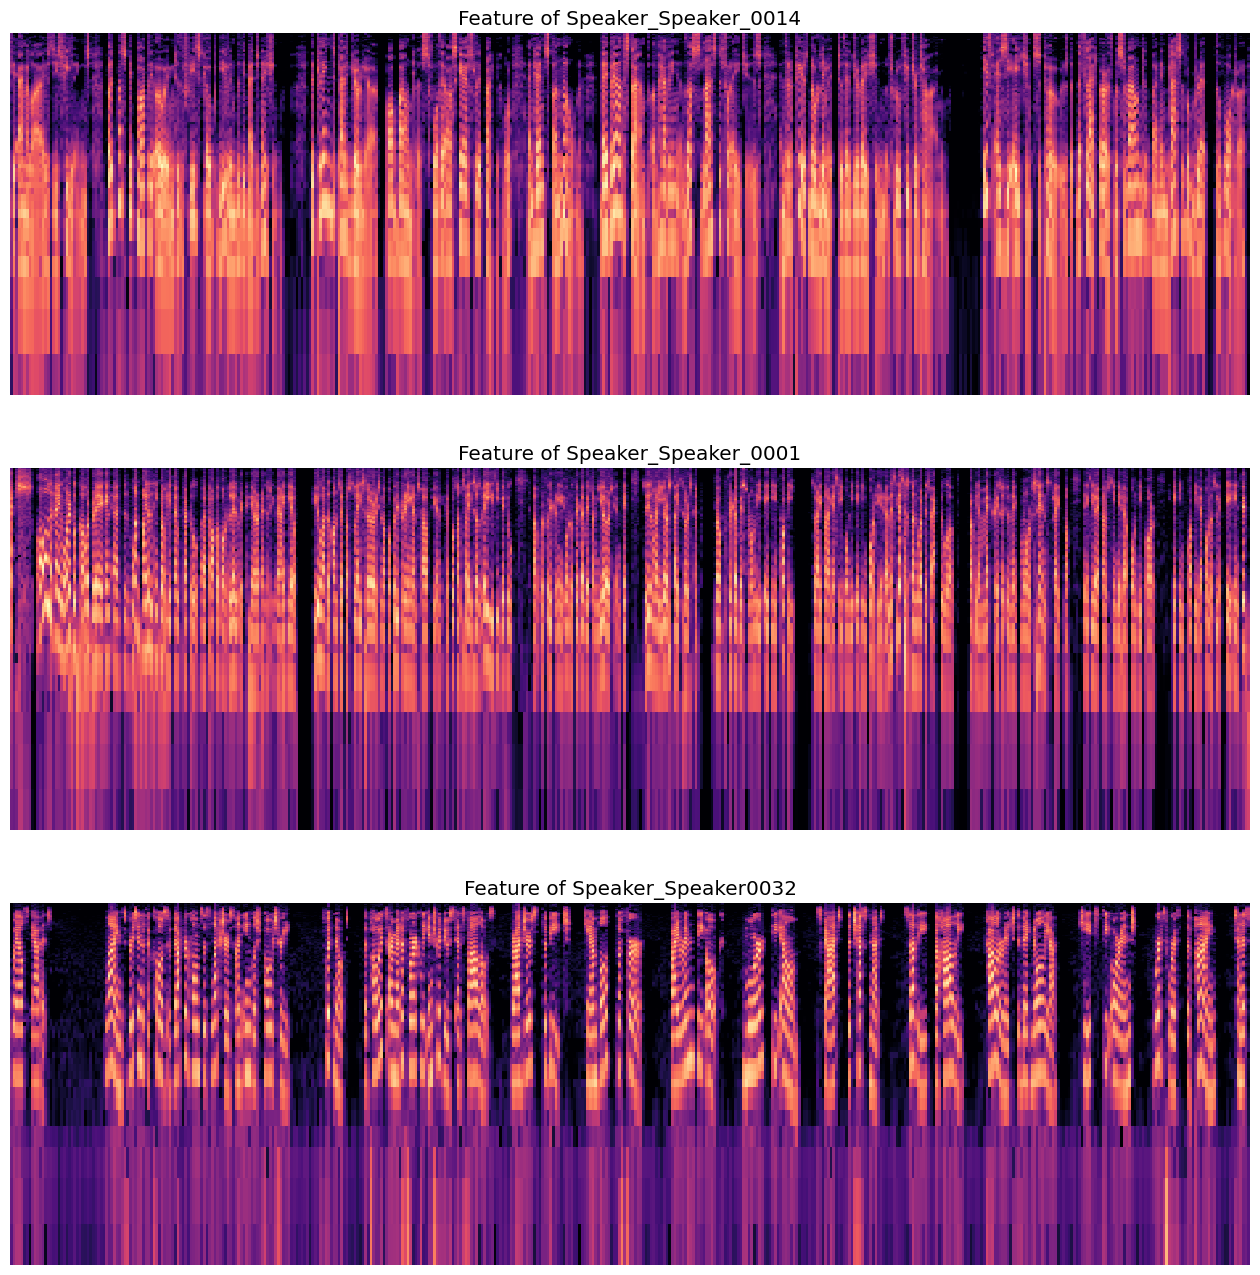

In [10]:
import random
import matplotlib.pyplot as plt

print("[INFO] Plotting sample fragments of extracted features...")

plt.figure(figsize=(16, 16))

for i in range(3):
    n = random.randrange(len(features))
    plt.subplot(3, 1, i + 1)
    librosa.display.specshow(features[n], sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Feature of Speaker_{labels[n]}')
    plt.axis("off") 

## Encode labels

In [11]:
labels, class_onehot_mapping = onehot_encode(labels)

[INFO] Performing one-hot encoding on multiple nodes...
Mapping between column indices and original classes:
{0: 'Speaker0026', 1: 'Speaker0027', 2: 'Speaker0028', 3: 'Speaker0029', 4: 'Speaker0030', 5: 'Speaker0031', 6: 'Speaker0032', 7: 'Speaker0033', 8: 'Speaker0034', 9: 'Speaker0035', 10: 'Speaker0036', 11: 'Speaker0037', 12: 'Speaker0038', 13: 'Speaker0039', 14: 'Speaker0040', 15: 'Speaker0041', 16: 'Speaker0042', 17: 'Speaker0043', 18: 'Speaker0044', 19: 'Speaker0045', 20: 'Speaker0046', 21: 'Speaker0047', 22: 'Speaker0048', 23: 'Speaker0049', 24: 'Speaker0050', 25: 'Speaker_0000', 26: 'Speaker_0001', 27: 'Speaker_0002', 28: 'Speaker_0003', 29: 'Speaker_0004', 30: 'Speaker_0005', 31: 'Speaker_0006', 32: 'Speaker_0007', 33: 'Speaker_0008', 34: 'Speaker_0009', 35: 'Speaker_0010', 36: 'Speaker_0011', 37: 'Speaker_0012', 38: 'Speaker_0013', 39: 'Speaker_0014', 40: 'Speaker_0015', 41: 'Speaker_0016', 42: 'Speaker_0017', 43: 'Speaker_0018', 44: 'Speaker_0019', 45: 'Speaker_0020', 46: '

## Split test train val

In [12]:
from sklearn.model_selection import train_test_split

#Stratified Sampling: If your dataset has imbalanced class distributions, you might want to consider using the stratify parameter in train_test_split to ensure that the class proportions are maintained across all splits (stratify=labels).

# train:test 70:30
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=32, stratify=labels)

features = []
labels = []

# test:val 40:60
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.60, random_state=32, stratify=y_test)

# train: 70%, val: 18%, test: 12%
print("Printing X_train info:")
np.info(X_train)

print("\nPrinting y_train info:")
np.info(y_train)

feature_width, feature_height = X_train.shape[1:3]
classes = y_train.shape[1]
print(f"\nDimensions of training data:\n\tX_train: {X_train.shape}\n\ty_train: {y_train.shape}")

Printing X_train info:
class:  ndarray
shape:  (3459, 128, 469)
strides:  (240128, 1876, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f02e7f14010
byteorder:  little
byteswap:  False
type: float32

Printing y_train info:
class:  ndarray
shape:  (3459, 50)
strides:  (400, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x16a28b90
byteorder:  little
byteswap:  False
type: float64

Dimensions of training data:
	X_train: (3459, 128, 469)
	y_train: (3459, 50)


## Calculate statistics about dataset

In [13]:
# Calculate the count of each class in the training set
train_class_counts = np.sum(y_train, axis=0)
train_class_dict = {f"Class {i}": count for i, count in enumerate(train_class_counts)}

# Calculate the count of each class in the validation set
val_class_counts = np.sum(y_val, axis=0)
val_class_dict = {f"Class {i}": count for i, count in enumerate(val_class_counts)}

# Calculate the count of each class in the test set
test_class_counts = np.sum(y_test, axis=0)
test_class_dict = {f"Class {i}": count for i, count in enumerate(test_class_counts)}

# Calculate the total number of samples in each set
total_train_samples = np.sum(train_class_counts)
total_val_samples = np.sum(val_class_counts)
total_test_samples = np.sum(test_class_counts)

# Print the class counts and percentages for each set aligned by class
max_len = max(len(key) for key in train_class_dict.keys())

print("Class".ljust(max_len + 5), "Train".ljust(15), "Validation".ljust(15), "Test".ljust(15))
print("-" * (max_len + 5 + 15 + 15 + 15))

for key in train_class_dict:
    percent_train = (train_class_dict[key] / total_train_samples) * 100
    percent_val = (val_class_dict[key] / total_val_samples) * 100
    percent_test = (test_class_dict[key] / total_test_samples) * 100

    print(key.ljust(max_len + 5),
          f"{train_class_dict[key]} ({percent_train:.2f}%)".ljust(15),
          f"{val_class_dict[key]} ({percent_val:.2f}%)".ljust(15),
          f"{test_class_dict[key]} ({percent_test:.2f}%)".ljust(15))

print(f'\nShape of the training set: {X_train.shape}')
print(f'Shape of the validation set: {X_val.shape}')
print(f'Shape of the test set: {X_test.shape}')

Class         Train           Validation      Test           
----------------------------------------------------------
Class 0       62.0 (1.79%)    16.0 (1.80%)    10.0 (1.69%)   
Class 1       64.0 (1.85%)    17.0 (1.91%)    11.0 (1.85%)   
Class 2       81.0 (2.34%)    21.0 (2.36%)    14.0 (2.36%)   
Class 3       42.0 (1.21%)    11.0 (1.24%)    7.0 (1.18%)    
Class 4       45.0 (1.30%)    11.0 (1.24%)    8.0 (1.35%)    
Class 5       65.0 (1.88%)    17.0 (1.91%)    11.0 (1.85%)   
Class 6       51.0 (1.47%)    13.0 (1.46%)    9.0 (1.52%)    
Class 7       48.0 (1.39%)    13.0 (1.46%)    8.0 (1.35%)    
Class 8       47.0 (1.36%)    12.0 (1.35%)    8.0 (1.35%)    
Class 9       44.0 (1.27%)    11.0 (1.24%)    8.0 (1.35%)    
Class 10      45.0 (1.30%)    11.0 (1.24%)    8.0 (1.35%)    
Class 11      76.0 (2.20%)    19.0 (2.13%)    13.0 (2.19%)   
Class 12      46.0 (1.33%)    12.0 (1.35%)    8.0 (1.35%)    
Class 13      71.0 (2.05%)    18.0 (2.02%)    12.0 (2.02%)   
Class 14   

## Saving data in TFRecord to avoid out of memory

In [14]:
import tensorflow as tf

# saving 2d spectrogram to save RAM memory
def serialize_example(spectrogram, label):
    feature = {
        'spectrogram': tf.train.Feature(float_list=tf.train.FloatList(value=spectrogram.reshape(-1))),
        'label': tf.train.Feature(float_list=tf.train.FloatList(value=label))  # save whole one-hot encoded list
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()
        
# Read from TFRecord
def parse_example(example_proto):
    feature_description = {
        'spectrogram': tf.io.FixedLenFeature([feature_width * feature_height], tf.float32),
        'label': tf.io.VarLenFeature(tf.float32)  # Używamy VarLenFeature dla list o zmiennej długości
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    spectrogram = tf.reshape(example['spectrogram'], [feature_width, feature_height])
    
    if use_3_channels:
        # Add the channel dimension
        spectrogram = tf.expand_dims(spectrogram, axis=-1) # Shape: (height, width, 1)
        
        # Stack to create 3 channels
        spectrogram = tf.repeat(spectrogram, 3, axis=2) # Shape: (height, width, 3)
        
        # # Preprocess the input for InceptionV3
        # spectrogram = tf.keras.applications.resnet50.preprocess_input(spectrogram)
    
    label = tf.sparse.to_dense(example['label'])  # Convert SparseTensor to dense Tensor
    return spectrogram, label

def saveAsTFRecord(target_file, features, labels):
    with tf.io.TFRecordWriter(target_file) as writer:
        for feature, label in zip(features, labels):
            example = serialize_example(feature, label)
            writer.write(example)

In [15]:
import os      

train_tfrecords_file = f"{tf_datasets_dir}/{unique_identifier}-train.tfrecords"
test_tfrecords_file = f"{tf_datasets_dir}/{unique_identifier}-test.tfrecords"
val_tfrecords_file = f"{tf_datasets_dir}/{unique_identifier}-val.tfrecords"

print(f"Datasets that will be used:\n\t{train_tfrecords_file}\n\t{test_tfrecords_file}\n\t{val_tfrecords_file}")

Datasets that will be used:
	./data/50_speakers_dataset/50_speakers_audio_data/TFRecords/30s-Mel-MyCNN-1024hops-512nfft-train.tfrecords
	./data/50_speakers_dataset/50_speakers_audio_data/TFRecords/30s-Mel-MyCNN-1024hops-512nfft-test.tfrecords
	./data/50_speakers_dataset/50_speakers_audio_data/TFRecords/30s-Mel-MyCNN-1024hops-512nfft-val.tfrecords


In [16]:
print(f"Saving training data to the TFRecords file...\n")
saveAsTFRecord(train_tfrecords_file, X_train, y_train)

print(f"Saving test data to the TFRecords file...\n")
saveAsTFRecord(test_tfrecords_file, X_test, y_test)

print(f"Saving validation data to the TFRecords file...\n")
saveAsTFRecord(val_tfrecords_file, X_val, y_val)

Saving training data to the TFRecords file...
Saving test data to the TFRecords file...
Saving validation data to the TFRecords file...


## Clear memory

In [17]:
num_of_train_samples = X_train.shape[0]
feature_width, feature_height = X_train.shape[1:3]
classes = y_train.shape[1]

# Librispeech
# feature_width, feature_height = 128, 469
# classes = 919

# 50_speakers
# feature_width, feature_height = 128
# classes = 

X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []

## Load tensorflow dataset to avoid OOM

In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Create datasets from TFRecords
train_dataset = (
    tf.data.TFRecordDataset(train_tfrecords_file)
    .map(parse_example)
    .shuffle(buffer_size=1024)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.TFRecordDataset(test_tfrecords_file)
    .map(parse_example)
    .shuffle(buffer_size=1024)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.TFRecordDataset(val_tfrecords_file)
    .map(parse_example)
    .shuffle(buffer_size=1024)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

tfds.benchmark(train_dataset, batch_size=batch_size)
tfds.benchmark(test_dataset, batch_size=batch_size)
tfds.benchmark(val_dataset, batch_size=batch_size)

print("Printing first 5 batches from train dataset:\n")
for spectrogram, label in train_dataset.take(5):
    print(f"Shape of spectrogram: {spectrogram.shape}, label: {label.shape}")

2024-08-12 19:48:39.998764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 19:48:40.033789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 19:48:40.033848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 19:48:40.035535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 19:48:40.035587: I tensorflow/compile


************ Summary ************


0it [00:00, ?it/s]

Examples/sec (First included) 1255.10 ex/sec (total: 3520 ex, 2.80 sec)
Examples/sec (First only) 35.69 ex/sec (total: 32 ex, 0.90 sec)
Examples/sec (First excluded) 1828.19 ex/sec (total: 3488 ex, 1.91 sec)

************ Summary ************


0it [00:00, ?it/s]

Examples/sec (First included) 1277.00 ex/sec (total: 640 ex, 0.50 sec)
Examples/sec (First only) 66.83 ex/sec (total: 32 ex, 0.48 sec)
Examples/sec (First excluded) 27196.35 ex/sec (total: 608 ex, 0.02 sec)

************ Summary ************


0it [00:00, ?it/s]

Examples/sec (First included) 1199.37 ex/sec (total: 928 ex, 0.77 sec)
Examples/sec (First only) 42.70 ex/sec (total: 32 ex, 0.75 sec)
Examples/sec (First excluded) 36967.49 ex/sec (total: 896 ex, 0.02 sec)
Printing first 5 batches from train dataset:
Shape of spectrogram: (32, 128, 469), label: (32, 50)
Shape of spectrogram: (32, 128, 469), label: (32, 50)
Shape of spectrogram: (32, 128, 469), label: (32, 50)
Shape of spectrogram: (32, 128, 469), label: (32, 50)
Shape of spectrogram: (32, 128, 469), label: (32, 50)


## Create model

In [19]:
%run commons.ipynb

if model_name == "ResNet50":
    model = create_resnet50_model(feature_width, feature_height, classes) # resnet - 3 channels
elif model_name == "BetterCNN":
    model = create_better_base_cnn_model(feature_width, feature_height, 1, classes) # 1/3 channels variant
else:
    model = create_base_cnn_model(feature_width, feature_height, 1, classes) # 1/3 channels variant

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 469, 64)      640       
                                                                 
 dropout (Dropout)           (None, 128, 469, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 118, 128)      73856     
                                                                 
 dropout_1 (Dropout)         (None, 32, 118, 128)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 118, 128)      147584    
                                                                 
 dropout_2 (Dropout)         (None, 32, 118, 128)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 30, 64)         7

## Fit model

In [20]:
from keras.src.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import tensorflow as tf
import time

epochs = 100

initial_learning_rate = 0.0005
final_learning_rate = 0.00001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)

# Tworzenie harmonogramu wykładniczego zmniejszania
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


opt = keras.optimizers.Adam(learning_rate=lr_schedule)
# opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{models_dir}/best_model_{unique_identifier}.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Record the start time
start_train_time = time.time()

H = model.fit(train_dataset.repeat(), epochs=epochs, validation_data=val_dataset, steps_per_epoch=steps_per_epoch,
              callbacks=[model_checkpoint])

# Record the end time
end_train_time = time.time()

# Calculate the training time
training_time = end_train_time - start_train_time
print(f"Training time: {training_time:.2f} seconds")

stopped_epoch = len(H.history['loss']) 

2024-08-12 19:48:47.033356: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/100


2024-08-12 19:48:48.180709: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-12 19:48:50.376119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-08-12 19:48:50.597596: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-12 19:48:52.035827: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x103c90b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-12 19:48:52.035857: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-08-12 19:48:52.041629: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set

128/128 [==============================] - ETA: 0s - loss: 3.8621 - accuracy: 0.1018
Epoch 1: val_accuracy improved from -inf to 0.02697, saving model to ./data/50_speakers_dataset/50_speakers_audio_data/models/best_model_30s-Mel-MyCNN-1024hops-512nfft.h5


2024-08-12 19:49:01.770470: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16626100097598128458
/home/tojoos/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


128/128 [==============================] - 15s 63ms/step - loss: 3.8621 - accuracy: 0.1018 - val_loss: 18.8073 - val_accuracy: 0.0270
Epoch 2/100
127/128 [============================>.] - ETA: 0s - loss: 2.0958 - accuracy: 0.4183
Epoch 2: val_accuracy improved from 0.02697 to 0.07416, saving model to ./data/50_speakers_dataset/50_speakers_audio_data/models/best_model_30s-Mel-MyCNN-1024hops-512nfft.h5
128/128 [==============================] - 7s 59ms/step - loss: 2.0894 - accuracy: 0.4205 - val_loss: 10.8214 - val_accuracy: 0.0742
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.8208
Epoch 3: val_accuracy improved from 0.07416 to 0.19101, saving model to ./data/50_speakers_dataset/50_speakers_audio_data/models/best_model_30s-Mel-MyCNN-1024hops-512nfft.h5
128/128 [==============================] - 7s 58ms/step - loss: 0.6960 - accuracy: 0.8208 - val_loss: 5.6192 - val_accuracy: 0.1910
Epoch 4/100
127/128 [============================>.] - ETA:

 ## Save model's history

In [21]:
import numpy as np

np.save(f'{results_dir}/history_{unique_identifier}-{training_time:.1f}s_traintime.npy', H.history)

## Optionally load created model (to avoid OOM)

In [22]:
from keras.models import load_model

# Load the model
model = load_model(f'{models_dir}/best_model_{unique_identifier}.h5')

## Run garbage collector to free memory

In [23]:
import tensorflow as tf

import gc
tf.keras.backend.clear_session()
gc.collect()

540

## Evaluate model

2024-08-12 19:59:39,483 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(128, 469)


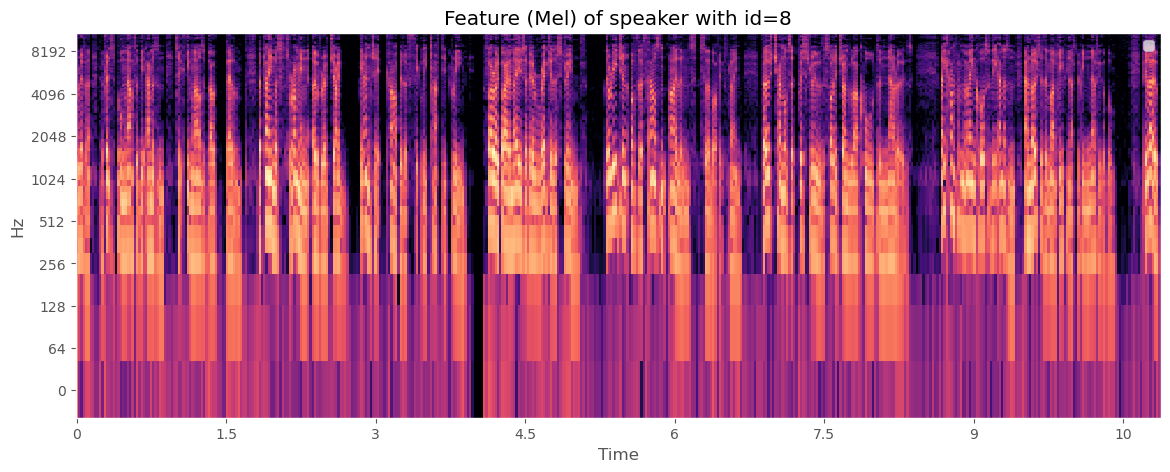

Shape of the test samples: (593, 128, 469)
Shape of the test labels: (593, 50)


In [24]:
import random

X_test = []
y_test = []

for spectrogram, label in test_dataset:
    X_test.extend(spectrogram.numpy())
    y_test.extend(label.numpy())

# Convert lists to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

random_idx = random.randint(0, len(X_test))
random_sample = X_test[random_idx]

print(random_sample.shape)

if use_3_channels:
    red_channel = random_sample[:, :, 0]
    green_channel = random_sample[:, :, 1]
    blue_channel = random_sample[:, :, 2]
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(14, 8))
    
    # Display each channel
    axs[0].imshow(red_channel, cmap='gray')
    axs[0].set_title('Red Channel')
    axs[0].axis('off')
    
    axs[1].imshow(green_channel, cmap='gray')
    axs[1].set_title('Green Channel')
    axs[1].axis('off')
    
    axs[2].imshow(blue_channel, cmap='gray')
    axs[2].set_title('Blue Channel')
    axs[2].axis('off')
else:
    fig, ax = plt.subplots(figsize=(14, 5))
    librosa.display.specshow(random_sample,  y_axis='log', x_axis='time', ax=ax)
    ax.legend(loc='upper right')
    ax.set(title=f'Feature ({chosen_feature}) of speaker with id={np.argmax(y_test[random_idx], axis=0)}')
    plt.show()

print(f'Shape of the test samples: {X_test.shape}')
print(f'Shape of the test labels: {y_test.shape}')

19/19 [==============================] - 1s 35ms/step
Predicted | Actual |  Confidence   |
   26     |   26   |    100.00  %  |  ✔ 
   12     |   45   |    83.13   %  |  ✘ 
   20     |   20   |    85.25   %  |  ✔ 
   27     |   27   |    99.99   %  |  ✔ 
   37     |   37   |    97.85   %  |  ✔ 
   33     |   33   |    100.00  %  |  ✔ 
   35     |   35   |    99.99   %  |  ✔ 
   26     |   26   |    100.00  %  |  ✔ 
   36     |   36   |    100.00  %  |  ✔ 
   47     |   47   |    99.91   %  |  ✔ 
   33     |   33   |    99.99   %  |  ✔ 
   48     |   48   |    99.91   %  |  ✔ 
   16     |   16   |    99.99   %  |  ✔ 
   6      |   6    |    54.96   %  |  ✔ 
   2      |   2    |    99.99   %  |  ✔ 
   31     |   31   |    99.95   %  |  ✔ 
   29     |   29   |    99.22   %  |  ✔ 
   30     |   30   |    99.99   %  |  ✔ 
   48     |   48   |    99.98   %  |  ✔ 
   31     |   31   |    68.66   %  |  ✔ 
   5      |   5    |    99.65   %  |  ✔ 
   33     |   33   |    100.00  %  |  ✔ 
   23  

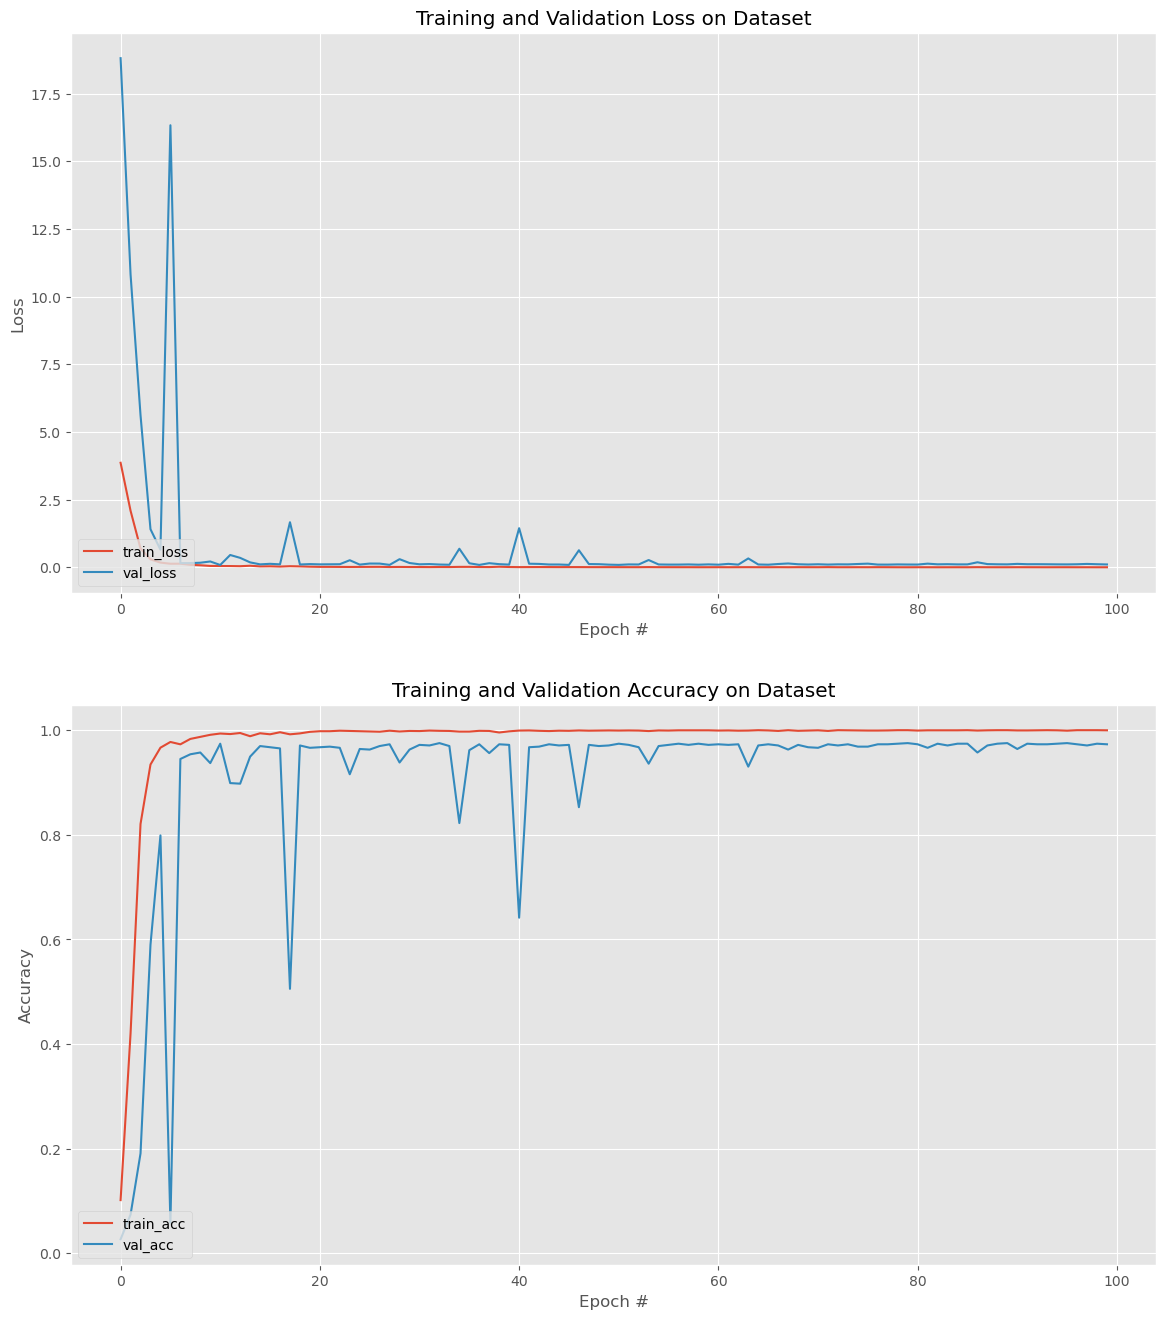

[INFO] Finished model evaluation
F1-score: 98.35%
Recall: 96.93%
Precision: 97.29%
Accuracy: 97.30%


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# y_pred = model.predict(test_dataset)
y_pred = model.predict(X_test)

y_pred_confidence = np.max(y_pred, axis=1)

y_pred_idx = np.argmax(y_pred, axis=1)  # softmax predictions need to be rounded
y_test_idx = np.argmax(y_test, axis=1)

precision = precision_score(y_test_idx, y_pred_idx, average='macro')
recall = recall_score(y_test_idx, y_pred_idx, average='macro')
f1 = f1_score(y_test_idx, y_pred_idx, average='macro')
accuracy = accuracy_score(y_test_idx, y_pred_idx)

y_true_list = np.array(y_pred_idx.tolist())

if y_true_list.shape != y_test.shape:
    y_test = np.argmax(y_test, axis=1)
    y_test = np.array(y_test.tolist())

print('Predicted | Actual |  Confidence   |')
for i in range(0, len(y_true_list)):
    correct = '✔' if y_true_list[i] == y_test[i] else '✘'
    print(f'{y_true_list[i]:^8}  |  {y_test[i]:^4}  |  {y_pred_confidence[i] * 100:^10.2f}%  |  {correct:^2}')


evaluate_model(H, y_true_list, y_test, stopped_epoch, show_confusion_matrix=False, interpolate=False, plot_file_name=f"{results_dir}/{unique_identifier}-{training_time:.1f}s_traintime")
#evaluate_model(None, y_pred, y_test, stopped_epoch, show_confusion_matrix=False, interpolate=False, plot_file_name=f"{dataset_name}-{chosen_feature}")

print(f"F1-score: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Precision: {f1 * 100:.2f}%")
print(f"Accuracy: {accuracy * 100:.2f}%")

with open(f"{results_dir}/{unique_identifier}-{training_time:.1f}s_traintime-accuracy-metrics.txt", 'w') as file:
    file.write(f"Model: {unique_identifier}\n")
    file.write(f"Training time: {training_time:.1f}s\n")
    file.write(f'\tPrecision: {precision}\n')
    file.write(f'\tRecall: {recall}\n')
    file.write(f'\tF1 Score: {f1}\n')
    file.write(f'\tAccuracy: {accuracy}\n')
